In [65]:
# # Install some packages
# %pip install rasterio
# %pip install earthpy

In [66]:
# Import packages
import pandas as pd                                                                                 # For loading the data into a DataFrame
import numpy as np                                                                                  # For data manipulation 
import tensorflow as tf                                                                             # For building the model
import rasterio                                                                                     # For reading raster files
import earthpy.plot as ep                                                                           # For plotting the data
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report         # For evaluating the model
import matplotlib.pyplot as plt                                                                     # For plotting the data
from matplotlib.colors import from_levels_and_colors                                                # For plotting the data
import os                                                                                           # For setting environment variables

# Suppress TensorFlow INFO and WARNING messages
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
tf.get_logger().setLevel('ERROR')

In [67]:
# Parameter
ALL_FEATURES = ['B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'EVI', 'NBR', 'NDMI', 'NDWI', 'NDBI', 'NDBaI', 'NDVI', 'elevation']
FEATURES = ['B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'EVI', 'NBR', 'NDMI', 'NDWI', 'NDBI', 'NDBaI', 'NDVI', 'elevation']
# FEATURES = ['B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'EVI', 'NBR', 'NDMI', 'NDWI', 'NDBI', 'NDBaI', 'elevation']
# FEATURES = ['B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'NDVI', 'elevation']
CLASSES = [1, 2, 3, 4, 5, 6]
LABEL = ['classvalue']
SPLIT = ['sample']
NUM_CLASSES = len(CLASSES)
NUM_OF_BANDS = len(FEATURES)
PALETTE = ['#8B0100', '#B86401', '#008080', '#87CEFA', '#65A300', '#006401']
SAMPLE_PATH = 'ndvi_data/Samples_LC_Jambi_2023_ALLFEATURES.csv'
IMAGE_PATH = 'ndvi_data/Landsat_Jogja_2023_ALLFEATURES.tif'

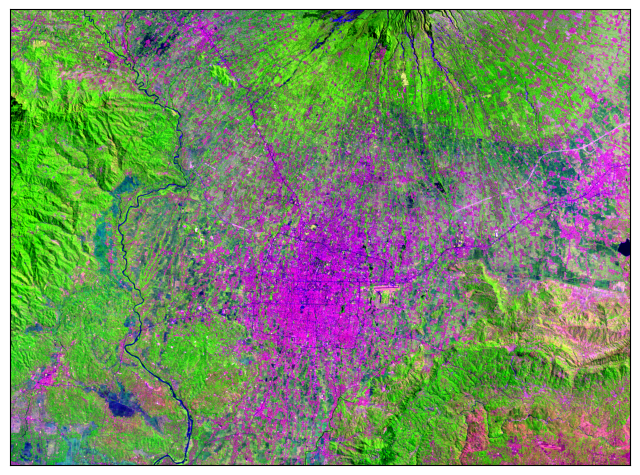

<Axes: >

In [68]:
# Load image
image = rasterio.open(IMAGE_PATH)
bandNum = image.count
height = image.height
width = image.width
crs = image.crs
transform = image.transform
shape = (height, width)

image_vis = []
for x in [6, 5, 4]:
  image_vis.append(image.read(x))
image_vis = np.stack(image_vis)

plot_size = (8, 8)
ep.plot_rgb(
  image_vis,
  figsize=plot_size,
  stretch=True,
)

In [69]:
# Read sample
samples = pd.read_csv(SAMPLE_PATH)
samples = samples.sample(frac = 1) # Shuffle data
samples

,B1,B2,B3,B4,B5,B6,B7,EVI,NBR,NDMI,NDWI,NDBI,NDBaI,NDVI,elevation,classvalue,sample
17029,0.031385,0.039662,0.055035,0.045795,0.228670,0.162312,0.077502,0.379103,0.493733,0.169720,-0.612027,-0.169720,0.353648,0.666296,13,5,train
12952,0.040955,0.048022,0.083140,0.076980,0.277593,0.215140,0.117102,0.363612,0.406618,0.126747,-0.539049,-0.126747,0.295078,0.565787,2,4,train
4122,0.030959,0.035524,0.054554,0.047720,0.218605,0.118629,0.067919,0.344944,0.525912,0.296460,-0.600571,-0.296460,0.271834,0.641641,732,1,train
7009,0.053632,0.065842,0.104287,0.115920,0.291563,0.326680,0.215058,0.294058,0.151011,-0.056802,-0.473096,0.056802,0.206045,0.431043,19,2,train
26890,0.012259,0.016384,0.042825,0.026902,0.331589,0.161350,0.076059,0.555946,0.626841,0.345355,-0.771242,-0.345355,0.359259,0.849913,1640,6,train
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5221,0.083360,0.093370,0.117240,0.148177,0.198255,0.233345,0.213820,0.090259,-0.037772,-0.081302,-0.256787,0.081302,0.043664,0.144552,12,1,test
28535,0.006951,0.010897,0.028222,0.016906,0.200263,0.083429,0.035180,0.375740,0.701158,0.411834,-0.752960,-0.411834,0.406789,0.844303,935,6,test
1003,0.081380,0.090372,0.111740,0.123510,0.202352,0.224847,0.198063,0.155739,0.010714,-0.052657,-0.288490,0.052657,0.063335,0.241950,738,1,train
578,0.054182,0.064550,0.102472,0.120567,0.212019,0.230430,0.183295,0.157533,0.072661,-0.041612,-0.348328,0.041612,0.113928,0.274970,25,1,train


In [70]:
# from ydata_profiling import ProfileReport
# ProfileReport(samples[FEATURES], title="Pandas Profiling Report")

In [71]:
# Split into train and test based on column
train = samples[samples['sample'] == 'train']
test = samples[samples['sample'] == 'test']

# Split between features and label
train_features = train[FEATURES]
train_label = train[LABEL]
test_features = test[FEATURES]
test_label = test[LABEL]

# Function to reshape array input
def reshape_input(array):
  shape = array.shape
  return array.reshape(shape[0], shape[1], 1)

# Convert samples dataframe (pandas) to numpy array
train_input = reshape_input(train_features.to_numpy())
test_input = reshape_input(test_features.to_numpy())

# Also make label data to categorical
train_output = tf.keras.utils.to_categorical(train_label.to_numpy())
test_output = tf.keras.utils.to_categorical(test_label.to_numpy())

# Show the data shape
print(f'Train features: {train_input.shape}\nTest features: {test_input.shape}\nTrain label: {train_output.shape}\nTest label: {test_output.shape}')

Train features: (23814, 15, 1)
Test features: (4830, 15, 1)
Train label: (23814, 7)
Test label: (4830, 7)


In [72]:
filtered_train = train[FEATURES + LABEL]
Label1 = filtered_train[filtered_train['classvalue'] == 1]
Label2 = filtered_train[filtered_train['classvalue'] == 2]
Label3 = filtered_train[filtered_train['classvalue'] == 3]
Label4 = filtered_train[filtered_train['classvalue'] == 4]
Label5 = filtered_train[filtered_train['classvalue'] == 5]
Label6 = filtered_train[filtered_train['classvalue'] == 6]

print("Label 1", Label1["classvalue"].count())
print("Label 2", Label2["classvalue"].count())
print("Label 3", Label3["classvalue"].count())
print("Label 4", Label4["classvalue"].count())
print("Label 5", Label5["classvalue"].count())
print("Label 6", Label6["classvalue"].count())

Label 1 4967
Label 2 1567
Label 3 4019
Label 4 2900
Label 5 3262
Label 6 7099


In [73]:
# Make model for our data
# Input shape
train_shape = train_input.shape
input_shape = (train_shape[1], train_shape[2])

# Model parameter
neuron = 64
drop = 0.4
kernel = 2
pool = 2

# Make sequential model
model = tf.keras.Sequential([
  tf.keras.Input(input_shape),
  tf.keras.layers.Conv1D(neuron * 2, kernel, activation='relu'),
  tf.keras.layers.Conv1D(neuron * 2, kernel, activation='relu'),
  tf.keras.layers.AveragePooling1D(pool),
  tf.keras.layers.Dropout(drop),
  tf.keras.layers.Conv1D(neuron * 1, kernel, activation='relu'),
  tf.keras.layers.Conv1D(neuron * 1, kernel, activation='relu'),
  # tf.keras.layers.AveragePooling1D(pool),
  tf.keras.layers.Dropout(drop),
  tf.keras.layers.GlobalAveragePooling1D(),
  
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.Dense(neuron * 2, activation='relu', kernel_regularizer=tf.keras.regularizers.L2(0.05)),
  tf.keras.layers.Dropout(drop),
  tf.keras.layers.Dense(neuron * 1, activation='relu', kernel_regularizer=tf.keras.regularizers.L2(0.05)),
  tf.keras.layers.Dropout(drop),
  tf.keras.layers.Dense(NUM_CLASSES + 1, activation='softmax')
])

model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_16 (Conv1D)              │ (None, 14, 128)        │           384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_17 (Conv1D)              │ (None, 13, 128)        │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling1d_3             │ (None, 6, 128)         │             0 │
│ (AveragePooling1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_16 (Dropout)            │ (None, 6, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_18 (Conv1D)              │ (None, 5, 64)          │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_19 (Conv1D)              │ (None, 4, 64)          │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_17 (Dropout)            │ (None, 4, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d_4      │ (None, 64)             │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_18 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_19 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 7)              │           455 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 75,271 (294.03 KB)

 Trainable params: 75,143 (293.53 KB)

 Non-trainable params: 128 (512.00 B)

In [74]:
# Train the model
from sklearn.utils.class_weight import compute_class_weight

train_output_flat = np.argmax(train_output, axis=1)

# Compute class weights
class_weights = compute_class_weight('balanced', classes=np.unique(train_output_flat), y=train_output_flat)
class_weights = dict(enumerate(class_weights))

print(class_weights)

# Compline the model
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss='CategoricalCrossentropy',
    metrics=['accuracy']
)

# Create callback to stop training if loss not decreasing
stop = tf.keras.callbacks.EarlyStopping(
    monitor='loss',
    patience=10,
    restore_best_weights=True
)

lr_callback = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    patience=5,
    factor=0.5,
    min_lr=1e-6
)

# Fit the model
result = model.fit(
    x=train_input, y=train_output,
    validation_data=(test_input, test_output),
    batch_size=1024,
    callbacks=[stop, lr_callback],  
    epochs=500,
    class_weight=class_weights
)

{0: np.float64(0.7990738876585464), 1: np.float64(2.532865347798341), 2: np.float64(0.9875590943020652), 3: np.float64(1.3686206896551725), 4: np.float64(1.2167381974248928), 5: np.float64(0.5590928299760529)}
Epoch 1/500


2024-11-27 14:19:27.933926: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng0{} for conv (f32[1024,128,1,14]{3,2,1,0}, u8[0]{0}) custom-call(f32[1024,128,1,13]{3,2,1,0}, f32[128,128,1,2]{3,2,1,0}), window={size=1x2}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBackwardInput", backend_config={"cudnn_conv_backend_config":{"activation_mode":"kNone","conv_result_scale":1,"leakyrelu_alpha":0,"side_input_scale":0},"force_earliest_schedule":false,"operation_queue_id":"0","wait_on_operation_queues":[]} is taking a while...
2024-11-27 14:19:27.935140: E external/local_xla/xla/service/slow_operation_alarm.cc:133] The operation took 1.690666164s
Trying algorithm eng0{} for conv (f32[1024,128,1,14]{3,2,1,0}, u8[0]{0}) custom-call(f32[1024,128,1,13]{3,2,1,0}, f32[128,128,1,2]{3,2,1,0}), window={size=1x2}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBackwardInput", backend_config={"cudnn_conv_backend_config":{"activation_mode":"kNone",

11/24 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.1371 - loss: 11.1211

2024-11-27 14:19:30.714572: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'input_reduce_transpose_fusion', 84 bytes spill stores, 76 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'input_reduce_select_transpose_fusion', 276 bytes spill stores, 264 bytes spill loads



24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step - accuracy: 0.1557 - loss: 11.0514

2024-11-27 14:19:34.569213: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'input_reduce_select_transpose_fusion_1', 328 bytes spill stores, 328 bytes spill loads



24/24 ━━━━━━━━━━━━━━━━━━━━ 15s 306ms/step - accuracy: 0.1570 - loss: 11.0471 - val_accuracy: 0.1764 - val_loss: 10.1411 - learning_rate: 1.0000e-04
Epoch 2/500
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.2563 - loss: 10.5746 - val_accuracy: 0.3948 - val_loss: 9.8276 - learning_rate: 1.0000e-04
Epoch 3/500
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.2955 - loss: 10.0430 - val_accuracy: 0.4640 - val_loss: 9.5380 - learning_rate: 1.0000e-04
Epoch 4/500
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.3242 - loss: 9.5064 - val_accuracy: 0.4681 - val_loss: 9.2506 - learning_rate: 1.0000e-04
Epoch 5/500
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.3538 - loss: 9.0904 - val_accuracy: 0.4685 - val_loss: 8.9576 - learning_rate: 1.0000e-04
Epoch 6/500
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.3821 - loss: 8.7406 - val_accuracy: 0.4683 - val_loss: 8.6669 - learning_rate: 1.0000e-04
Epoch 7/500
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.4073 - los

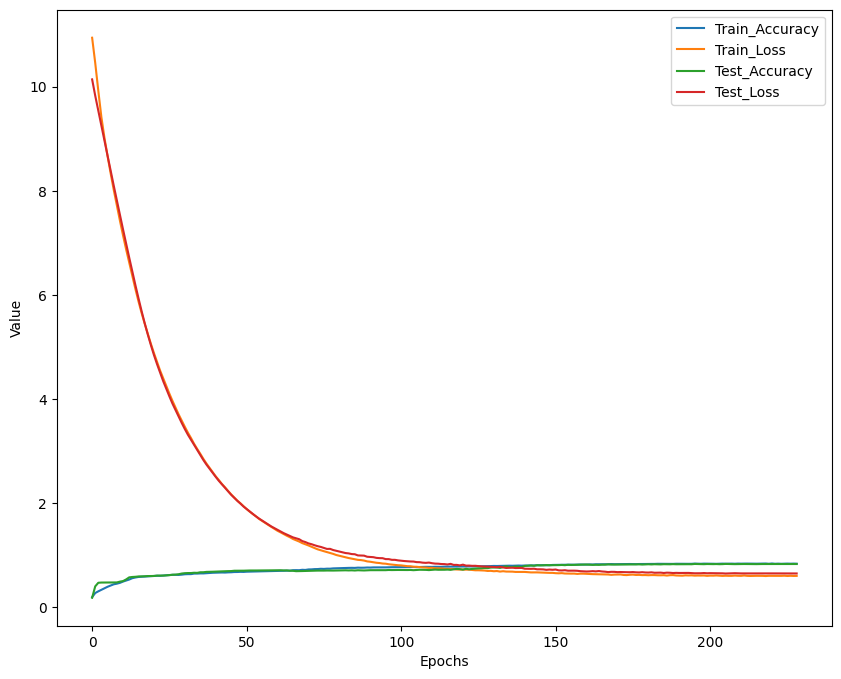

In [75]:
# Show history
history = pd.DataFrame(result.history)

plt.figure(figsize = (10, 8))
plt.plot(range(len(history['accuracy'].values.tolist())), history['accuracy'].values.tolist(), label = 'Train_Accuracy')
plt.plot(range(len(history['loss'].values.tolist())), history['loss'].values.tolist(), label = 'Train_Loss')
plt.plot(range(len(history['val_accuracy'].values.tolist())), history['val_accuracy'].values.tolist(), label = 'Test_Accuracy')
plt.plot(range(len(history['val_loss'].values.tolist())), history['val_loss'].values.tolist(), label = 'Test_Loss')
plt.xlabel('Epochs')
plt.ylabel('Value')
plt.legend()
plt.show()

151/151 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step
              precision    recall  f1-score   support

           1       0.93      0.97      0.95       872
           2       0.73      0.85      0.79       307
           3       0.77      0.72      0.75       710
           4       0.98      0.98      0.98       531
           5       0.90      0.52      0.66       967
           6       0.73      0.93      0.82      1443

    accuracy                           0.82      4830
   macro avg       0.84      0.83      0.82      4830
weighted avg       0.84      0.82      0.82      4830



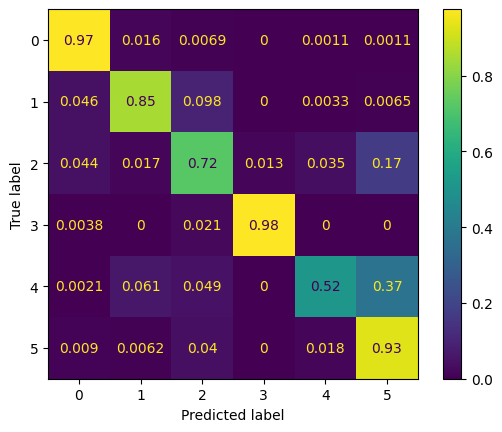

In [76]:
# Predict test data
prediction = np.argmax(model.predict(test_input), 1).flatten()
label = np.argmax(test_output, 1).flatten()

# Confusion matrix
cm = confusion_matrix(label, prediction, normalize='true')
cm = ConfusionMatrixDisplay(cm)
cm.plot()

# Classification report
print(classification_report(label, prediction))

2024-11-27 14:20:35.711734: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng33{k2=15,k6=0,k13=1,k14=0,k22=0} for conv (f32[81920,64,1,4]{3,2,1,0}, u8[0]{0}) custom-call(f32[81920,64,1,5]{3,2,1,0}, f32[64,64,1,2]{3,2,1,0}, f32[64]{0}), window={size=1x2}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"cudnn_conv_backend_config":{"activation_mode":"kRelu","conv_result_scale":1,"leakyrelu_alpha":0,"side_input_scale":0},"force_earliest_schedule":false,"operation_queue_id":"0","wait_on_operation_queues":[]} is taking a while...
2024-11-27 14:20:35.737971: E external/local_xla/xla/service/slow_operation_alarm.cc:133] The operation took 1.676091057s
Trying algorithm eng33{k2=15,k6=0,k13=1,k14=0,k22=0} for conv (f32[81920,64,1,4]{3,2,1,0}, u8[0]{0}) custom-call(f32[81920,64,1,5]{3,2,1,0}, f32[64,64,1,2]{3,2,1,0}, f32[64]{0}), window={size=1x2}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasA

31/31 ━━━━━━━━━━━━━━━━━━━━ 7s 113ms/step


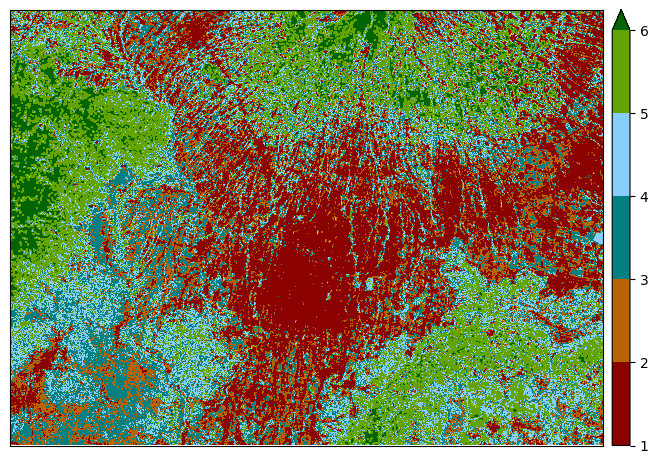

<Axes: >

In [77]:
# Predict image using the model
image_input = []
used_image_feature = [i + 1 for i in range(0, len(ALL_FEATURES)) if image.descriptions[i] in FEATURES]
for i in used_image_feature:
  image_input.append(image.read(i))
image_input = reshape_input(np.stack(image_input).reshape(NUM_OF_BANDS, -1).T)

# Predict
prediction = model.predict(image_input, batch_size=4096*20)
prediction = np.argmax(prediction, 1)
prediction = prediction.reshape(shape[0], shape[1])

# Visualize
cmap, norm = from_levels_and_colors(CLASSES, PALETTE, extend='max')
ep.plot_bands(prediction, cmap=cmap, norm=norm, figsize=plot_size)